### Example using DataShader and maps to plot business in SF

#### This is based on the following blog post
https://towardsdatascience.com/large-scale-visualizations-and-mapping-with-datashader-d465f5c47fb5

This may be of some use when it comes to building a tool to assess fire risk in the city using publically avaialble datasets

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from functools import partial
from datetime import datetime
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from IPython.core.display import HTML, display
from colorcet import fire, bmw

import holoviews as hv
import geoviews as gv
from holoviews.operation.datashader import datashade, dynspread
hv.extension('bokeh', width=95)

#These parameters are used to set up the size of the figure that we will make
%opts RGB     [width=1200 height=682 xaxis=None yaxis=None show_grid=False] 
%opts Shape (fill_alpha=0 line_width=1.5) [apply_ranges=False tools=['tap']] 
%opts Points [apply_ranges=False] WMTS (alpha=0.5)
%opts Overlay [width=900 height=525 xaxis=None yaxis=None]
%matplotlib inline

ModuleNotFoundError: No module named 'geoviews'

In [46]:
businesses = pd.read_csv('reg_bus_sf.csv')

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
businesses['City'].unique()

array(['San Francisco', 'El+cerrito', 'San+francisco', ...,
       'South+san+francicso', 'South Sf', 'Santa++rosa'], dtype=object)

In [48]:
len(businesses)

230345

In [49]:
def clean_dataset(business_data):
    
    '''Clean up the dataset so that we just have open businesses in SF'''
    dataset = business_data.copy()
    dataset.dropna(subset=['Business Location','Business End Date'],inplace=True)
    dataset = dataset[dataset['City'].isin(['San Francisco','San+francisco'])]
    dataset['City'] = ['San Francisco']*len(dataset)
    dataset.reset_index(inplace=True,drop=True)
    return dataset

def extract_lon(row):
    
    parts = row.split('(')
    try:
        return float(parts[-1].split(',')[1][:-1])
    except:
        return np.NaN

def extract_lat(row):
    
    parts = row.split('(')
    try:
        return float(parts[-1].split(',')[0])
    except:
        return np.NaN
    
    

In [50]:
data = clean_dataset(businesses)

In [51]:
data['lon'] = data['Business Location'].apply(extract_lon)
data['lat'] = data['Business Location'].apply(extract_lat)

In [52]:
len(data)

42568

Convert the lon and lat fields to easting and northing columns

In [53]:
from datashader.utils import lnglat_to_meters as webm 
data.loc[:,'easting'], data.loc[:,'northing'] = webm(data['lon'],data['lat'])

Get the lat and lon range of the map we want to plot

In [54]:
lon_min = data['lon'].quantile(0.01)
lon_max = data['lon'].quantile(0.99)
lat_min = data['lat'].quantile(0.01)
lat_max = data['lat'].quantile(0.99)

In [55]:
southwest = webm(lon_min,lat_min)
northeast = webm(lon_max,lat_max)
SF_region = zip(southwest,northeast)

In [56]:
data['Business Start Date'] = pd.to_datetime(data['Business Start Date'])
data['Business End Date'] = pd.to_datetime(data['Business End Date'])

In [57]:
# Age based on date in row.
date_now = datetime.now()
def get_age(row, column_str):
    return (date_now.year - row[column_str].year) * 12 + date_now.month - row[column_str].month

In [58]:
data['business_age'] = data.apply(lambda row: get_age(row, 'Business Start Date'), axis = 1)

In [65]:
age_oldest_10 = data['business_age'].quantile(0.9)
age_oldest_10

299.0

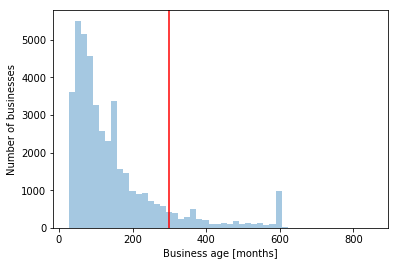

In [71]:
sns.distplot(data['business_age'],kde=False,bins=50)
plt.xlabel('Business age [months]')
plt.ylabel('Number of businesses')
plt.axvline(x=age_oldest_10,color='red')

Set up the map and plot on a basic background

In [72]:
plot_width = int(500)
plot_height = int(500)
background = "black"
export = partial(export_image,background=background,export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))
display(HTML("<style>.container {width:100% !important; }</style>"))

Set up the map canvas object

In [73]:
#Note that we need to pass the region in as argument!
cvs = ds.Canvas(plot_width,plot_height,*SF_region)
agg = cvs.points(data,'easting','northing')

Plot the map

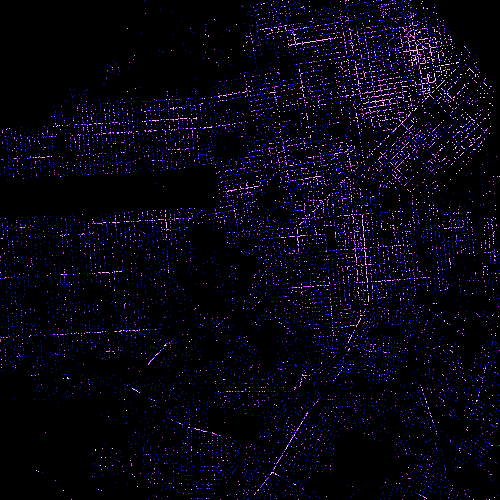

In [74]:
export(tf.shade(agg,cmap=cm(bmw,0.2),how='eq_hist'),"SF businesses")

### What about the oldest businesses?

In [75]:
data.columns

Index(['Location Id', 'Business Account Number', 'Ownership Name', 'DBA Name',
       'Street Address', 'City', 'State', 'Source Zipcode',
       'Business Start Date', 'Business End Date', 'Location Start Date',
       'Location End Date', 'Mail Address', 'Mail City', 'Mail Zipcode',
       'Mail State', 'NAICS Code', 'NAICS Code Description', 'Parking Tax',
       'Transient Occupancy Tax', 'LIC Code', 'LIC Code Description',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries',
       'Business Corridor', 'Business Location', 'lon', 'lat', 'easting',
       'northing', 'business_age'],
      dtype='object')

In [82]:
#Get the oldest 10% of the businesses
oldest = data[data['business_age'] >= age_oldest_10]

In [83]:
len(oldest)

4322

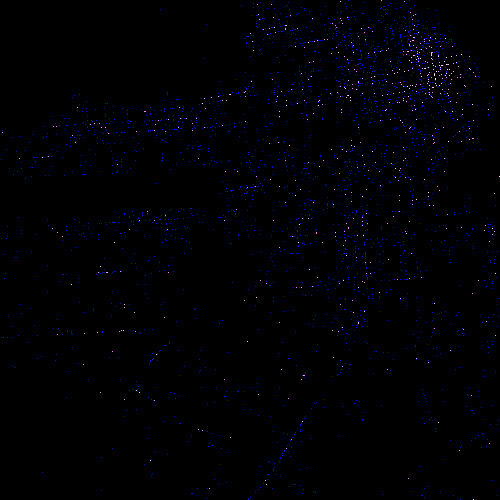

In [84]:
agg = cvs.points(oldest,'easting','northing')
export(tf.shade(agg,cmap=cm(bmw,0.2),how='eq_hist'),"SF businesses")

In [85]:
#Make a map where the dots are colored by business age
url="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.png"
geomap = gv.WMTS(url)
points = hv.Points(gv.Dataset(data, kdims=['easting', 'northing'], vdims=['business_age']))
biz_cat = dynspread(datashade(points, color_key=bmw, element_type=gv.Image, aggregator=ds.count()))
geomap * biz_cat

:DynamicMap   []
   :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .RGB.I  :RGB   [easting,northing]   (R,G,B,A)